# Exercise 1b - Testing Transformer

The objective of this task is to build a question answering and text summarization model (for Exercise 1a).
<br>

- <b>Group 3:</b> Cesar Laura, Ecker Annina, Dilly Julian
- <b>Section of Paper:</b> "Multi-Head Attention + Scaled Dot Production"
<br>
<br>
<div class="alert alert-block alert-info">
Note: Each of us worked on all tasks independently. We later discussed our findings and merged the best/most representative parts with eachother in one Notebook.
</div>

In [1]:
#!pip install -r requirements.txt
#!pip install bert_score

In [8]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU device")


Using MPS device


In [122]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import pipeline
from transformers import RobertaTokenizer, RobertaForSequenceClassification

import textwrap

import bert_score

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize


[nltk_data] Downloading package punkt to /Users/annina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
text = """Scaled Dot-Product Attention
We call our particular attention "Scaled Dot-Product Attention". The input consists of
queries and keys of dimension d_k, and values of dimension d_v. We compute the dot products of the
query with all keys, divide each by square root(d_k), and apply a softmax function to obtain the weights on the
values. In practice, we compute the attention function on a set of queries simultaneously, packed together
into a matrix Q. The keys and values are also packed together into matrices K and V .
The two most commonly used attention functions are additive attention, and dot-product (multiplicative) attention. 
Dot-product attention is identical to our algorithm, except for the scaling factor of square root(1/d_k). 
Additive attention computes the compatibility function using a feed-forward network with
a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is
much faster and more space-efficient in practice, since it can be implemented using highly optimized
matrix multiplication code.
While for small values of d_k the two mechanisms perform similarly, additive attention outperforms
dot product attention without scaling for larger values of d_k. We suspect that for large values of
d_k, the dot products grow large in magnitude, pushing the softmax function into regions where it has
extremely small gradients. To counteract this effect, we scale the dot products by square root(1/d_k).

Multi-Head Attention
Instead of performing a single attention function with dmodel-dimensional keys, values and queries,
we found it beneficial to linearly project the queries, keys and values h times with different, learned
linear projections to dk, dk and dv dimensions, respectively. On each of these projected versions of
queries, keys and values we then perform the attention function in parallel, yielding dv-dimensional
output values. These are concatenated and once again projected, resulting in the final values.
Multi-head attention allows the model to jointly attend to information from different representation
subspaces at different positions. With a single attention head, averaging inhibits this.

In this work we employ h = 8 parallel attention layers, or heads. For each of these we use
d_k = d_v = d_model/h = 64. Due to the reduced dimension of each head, the total computational cost
is similar to that of single-head attention with full dimensionality.

Applications of Attention in our Model
The Transformer uses multi-head attention in three different ways:
- In "encoder-decoder attention" layers, the queries come from the previous decoder layer,
and the memory keys and values come from the output of the encoder. This allows every
position in the decoder to attend over all positions in the input sequence. This mimics the
typical encoder-decoder attention mechanisms in sequence-to-sequence models.
- The encoder contains self-attention layers. In a self-attention layer all of the keys, values
and queries come from the same place, in this case, the output of the previous layer in the
encoder. Each position in the encoder can attend to all positions in the previous layer of the
encoder.
- Similarly, self-attention layers in the decoder allow each position in the decoder to attend to
all positions in the decoder up to and including that position. We need to prevent leftward
information flow in the decoder to preserve the auto-regressive property. We implement this
inside of scaled dot-product attention by masking out (setting to minus infinity) all values in the input
of the softmax which correspond to illegal connections.

Position-wise Feed-Forward Networks
In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully
connected feed-forward network, which is applied to each position separately and identically. This
consists of two linear transformations with a ReLU activation in between.
While the linear transformations are the same across different positions, they use different parameters
from layer to layer. Another way of describing this is as two convolutions with kernel size 1.
The dimensionality of input and output is d_model = 512, and the inner-layer has dimensionality
d_f_f = 2048.

Embeddings and Softmax
Similarly to other sequence transduction models, we use learned embeddings to convert the input
tokens and output tokens to vectors of dimension dmodel. 
We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. 
In our model, we share the same weight matrix between the two embedding layers and the pre-softmax
linear transformation. In the embedding layers, we multiply those weights by square root(d_dmodel).
"""

<hr style="height:10px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">

# Model: Distilbert-Base-Cased-Distilled-Squad

Source: __[Huggingface - Distilbert/Distilbert](https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad)__

In [105]:
question_answerer = pipeline("question-answering", model='distilbert-base-cased-distilled-squad', device="mps")

In [106]:
question_distilbert1 = "How many parallel attention layers are used?"
outputs_distilbert1 = question_answerer(question=question_distilbert1, context=text)
pd.DataFrame([outputs_distilbert1])

,score,start,end,answer
0,0.944151,2203,2208,h = 8


In [107]:
question_distilbert2 = "What does the Transformer use?"
outputs_distilbert2 = question_answerer(question=question_distilbert2, context=text)
pd.DataFrame([outputs_distilbert2])

,score,start,end,answer
0,0.953861,2502,2522,multi-head attention


In [108]:
question_distilbert3 = "What dimensionality has the inner-layer?"
outputs_distilbert3 = question_answerer(question=question_distilbert3, context=text)
pd.DataFrame([outputs_distilbert3])

,score,start,end,answer
0,0.877487,4235,4247,d_f_f = 2048


<hr style="height:10px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">

# Model: Deepset/MiniLM-Uncased-Squad2

Source: __[Huggingface - Deepset/MiniLM](https://huggingface.co/deepset/minilm-uncased-squad2)__

In [114]:
question_answerer2 = pipeline("question-answering", model="deepset/minilm-uncased-squad2", device="mps")

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [115]:
question_miniLM1 = "How many parallel attention layers are used?"
outputs_miniLM1 = question_answerer2(question=question_miniLM1, context=text)
pd.DataFrame([outputs_miniLM1])


,score,start,end,answer
0,0.874737,2203,2208,h = 8


In [116]:
question_miniLM2 = "What does the Transformer use?"
outputs_miniLM2 = question_answerer2(question=question_miniLM2, context=text)
pd.DataFrame([outputs_miniLM2])


,score,start,end,answer
0,0.752412,2502,2522,multi-head attention


In [117]:
question_miniLM3 = "What dimensionality has the inner-layer?"
outputs_miniLM3 = question_answerer2(question=question_miniLM3, context=text)
pd.DataFrame([outputs_miniLM3])


,score,start,end,answer
0,0.935633,4235,4247,d_f_f = 2048


<hr style="height:10px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">

# Model: Deepset/RoBERTa-Base-Squad2

Source: __[Huggingface - Deepset/RoBERTa-Base-Squad2](https://huggingface.co/deepset/roberta-base-squad2)__


In [101]:
question_answerer3 = pipeline("question-answering", "deepset/roberta-base-squad2", device="mps")

In [102]:
question_roberta1 = "How many parallel attention layers are used?"
outputs_roberta1 = question_answerer3(question=question_roberta1, context=text)
pd.DataFrame([outputs_roberta1])


,score,start,end,answer
0,0.719232,2203,2208,h = 8


In [103]:
question_roberta2 = "What does the Transformer use?"
outputs_roberta2 = question_answerer3(question=question_roberta2, context=text)
pd.DataFrame([outputs_roberta2])


,score,start,end,answer
0,0.576957,2502,2522,multi-head attention


In [104]:
question_roberta3 = "What dimensionality has the inner-layer?"
outputs_roberta3 = question_answerer3(question=question_roberta3, context=text)
pd.DataFrame([outputs_roberta3])


,score,start,end,answer
0,0.268242,4235,4247,d_f_f = 2048


<hr style="height:10px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">

In [118]:
outputs_dicts = {
    "Distilbert1": outputs_distilbert1,
    "Distilbert2": outputs_distilbert2,
    "Distilbert3": outputs_distilbert3,
    "miniLM1": outputs_miniLM1,
    "miniLM2": outputs_miniLM2,
    "miniLM3": outputs_miniLM3,
    "RoBERTa1": outputs_roberta1,
    "RoBERTa2": outputs_roberta2,
    "RoBERTa3": outputs_roberta3
}

dfs = []
for model_name, output_dict in outputs_dicts.items():
    df = pd.DataFrame([output_dict])
    df["Model"] = model_name
    dfs.append(df)

In [119]:
combined_dfs = pd.concat(dfs, ignore_index=True)

combined_dfs.reset_index(inplace=True)

cols = ["Model"] + [col for col in combined_dfs.columns if col != "Model"]

combined_df = combined_dfs[cols].reset_index(drop=True)

combined_df.set_index("Model", inplace=True)

In [120]:
combined_df.T

Model,Distilbert1,Distilbert2,Distilbert3,miniLM1,miniLM2,miniLM3,RoBERTa1,RoBERTa2,RoBERTa3
index,0,1,2,3,4,5,6,7,8
score,0.944151,0.953861,0.877487,0.874737,0.752412,0.935633,0.719232,0.576957,0.268242
start,2203,2502,4235,2203,2502,4235,2203,2502,4235
end,2208,2522,4247,2208,2522,4247,2208,2522,4247
answer,h = 8,multi-head attention,d_f_f = 2048,h = 8,multi-head attention,d_f_f = 2048,h = 8,multi-head attention,d_f_f = 2048


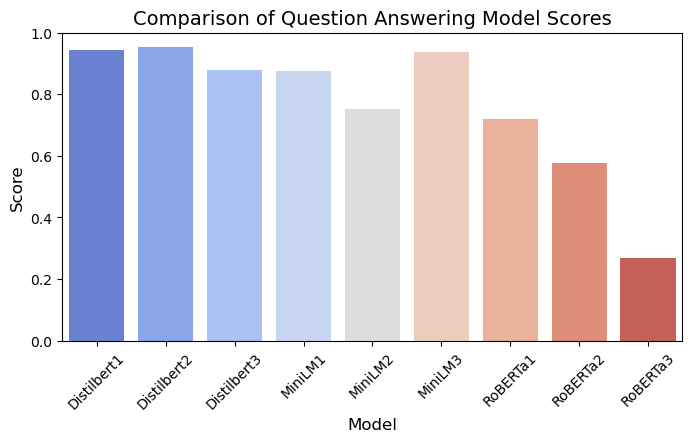

In [124]:
model_names = ["Distilbert1", "Distilbert2", "Distilbert3", "MiniLM1", "MiniLM2", "MiniLM3", "RoBERTa1", "RoBERTa2", "RoBERTa3"]
scores = [0.944151, 0.953861, 0.877487, 0.874737, 0.752412, 0.935633, 0.719232, 0.576957, 0.268242]

plt.figure(figsize=(8, 4))
sns.barplot(x=model_names, y=scores, palette="coolwarm")

plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Comparison of Question Answering Model Scores", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.show()


<hr style="height:10px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">

# Résumé

The results indicate strong performance across multiple models, with **DistilBERT1, MiniLM1,** and **RoBERTa1** correctly identifying *"h = 8"* as the answer. **RoBERTa2** and **MiniLM2** return *"multi-head attention"*, which is relevant but not as precise as **Distilbert2**. Interestingly enough is that as well as **DistilBERT3**, **MiniLM3** and **RoBERTa3** deliver the same output *"d_f_f = 2048"*, **RoBERTa3** has a very low confidence in its prediction.<br><br>

The highest scores are achieved by **DistilBERT2 (0.95)**, **DistilBERT1 (0.94)** and **MiniLM3 (0.93)**, indicating high confidence in their answers. **RoBERTa** models generally have lower scores, with **RoBERTa3** performing the weakest **(0.26)**, suggesting a greater likelihood uncertain answers.<br><br>